In [3]:
import numpy as np
from random import shuffle
import abc
import matplotlib.pyplot as plt
from IPython.display import Math
from IPython.display import Latex
%matplotlib inline

## Activations

In [130]:
class Activation(metaclass=abc.ABCMeta):
    
    @abc.abstractmethod
    def function(self, x):
        """Implementation of the activation function."""
        
    @abc.abstractmethod
    def derivative(self, x):
        """Derivative of the activation function."""

### Sigmoid

In [174]:
Latex(r"""\begin{align}
f(x)=\frac{1}{1+e^{-x}}=\sigma(x)\quad
f'(x)=\sigma(x)\cdot(1-\sigma(x))=\frac{e^{-x}}{{(1+e^{-x}})^2}
\end{align}""")

<IPython.core.display.Latex object>

In [132]:
class Sigmoid(Activation):
    
    def function(self, x):
        return 1 / (1 + np.exp(-x))
    
    def derivative(self, x):
        # alternative: self.function(x)*(1 - self.function(X))
        return np.exp(-x)/((1+np.exp(-x))**2)

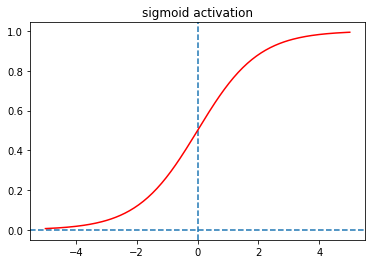

In [133]:
x = np.linspace(-5, 5, 200)
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
plt.title("sigmoid activation")
plt.plot(x,Sigmoid().function(x), color="red")

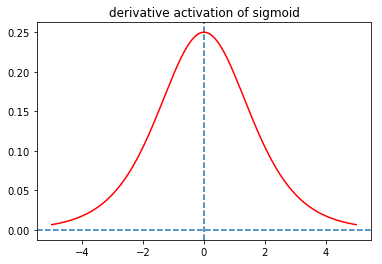

In [134]:
x = np.linspace(-5, 5, 200)
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
plt.title("derivative activation of sigmoid")
plt.plot(x,Sigmoid().derivative(x), color="red")

### ReLU

In [176]:
Latex(r"""\begin{align}
f(x)=\begin{cases}
  x, & \text{if } x > 0, \\
  0, & \text{otherwise}.
\end{cases}\quad
f'(x)=\begin{cases}
  1, & \text{if } x > 0, \\
  0, & \text{otherwise}.
\end{cases}
\end{align}""")

<IPython.core.display.Latex object>

In [136]:
class Relu(Activation):
    
    def function(self, x):
        return x * (x > 0)

    def derivative(self, x):
        return np.array(self.function(x) != 0, dtype="int")

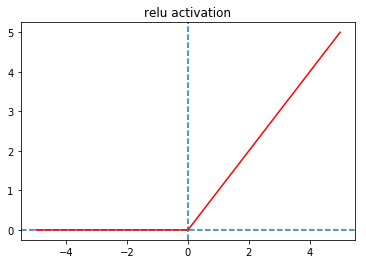

In [137]:
x = np.linspace(-5, 5, 200)
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
plt.title("relu activation")
plt.plot(x,Relu().function(x), color="red")

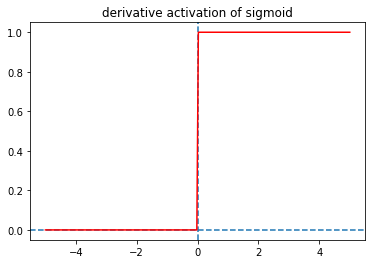

In [138]:
x = np.linspace(-5, 5, 200)
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
plt.title("derivative activation of sigmoid")
plt.plot(x,Relu().derivative(x), color="red")

### Hyperbolic Tangent

In [173]:
Latex(r"""\begin{align}
f(x)=\frac{e^{2x}-1}{e^{2x}+1}
\quad
f'(x)=\frac{4}{{e^{2x}+2+e^{-2x}}}
\end{align}""")

<IPython.core.display.Latex object>

In [140]:
class Tanh(Activation):
    
    def function(self, x):
        return (np.exp(2*x) - 1)/(np.exp(2*x) + 1)

    def derivative(self, x):
        # hyperbolic secant to the power of 2
        return (4/(np.exp(2*x) + 2 + np.exp(-2*x)))

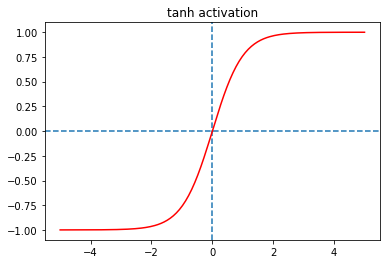

In [141]:
x = np.linspace(-5, 5, 200)
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
plt.title("tanh activation")
plt.plot(x,Tanh().function(x), color="red")

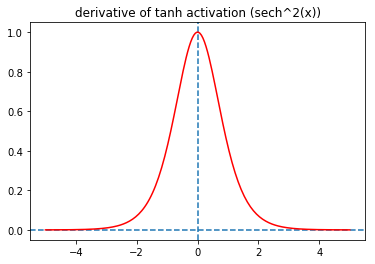

In [142]:
x = np.linspace(-5, 5, 200)
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
plt.title("derivative of tanh activation (sech^2(x))")
plt.plot(x,Tanh().derivative(x), color="red")

### Linear

In [143]:
class Linear(Activation):
    
    def function(self, x):
        return x

    def derivative(self, x):
        return 1

## Input Pipeline

In [177]:
class Input_pipeline:
    
    def __init__(self, x, y, batch_size):
        self.data = [(x[index], y[index]) for index in range(len(x))]
        self.size = len(self.data)
        self.batch_size = batch_size
        self.index = 0
    
    def get_next_separated(self):
        batch = self.step()
        return (np.array([element[0] for element in batch]),
                np.array([element[1] for element in batch])) 
    
    def step(self):
        if self.index + self.batch_size > self.size:
            self.index = 0
            shuffle(self.data)
        
        batch = self.data[self.index:self.index+self.batch_size]
        self.index += self.batch_size
        
        return batch 

## Layers

In [149]:
class Layer:
    
    def __init__(self, activation, size):
        self.activation = activation
        self.value = None
        self.size = size
        
    def forward(self, x):
        self.value = self.activation.function(x)
        return self.value
        
    def backward(self):
        return self.activation.derivative(self.value)


In [178]:
class Dropout(Layer):
    
    def __init__(self, activation, size):
        super.__init__(activation, size)
        

## Perceptron

In [179]:
class Mlp:
    
    def __init__(self, layers):
        self.layers = layers
        
        self.weight_matrices, self.biases = self.init_weights()
        
        self.dws = [0]*len(self.weight_matrices)
        self.dbs = [0]*len(self.weight_matrices)
        
        self.lrate = 0.001
        self.momentum = 0.1
        
    def init_weights(self):
        weights = []
        biases = []
        for index in range(len(self.layers)-1):
            weights.append(np.random.rand(self.layers[index].size, self.layers[index + 1].size))
            biases.append(np.random.rand(1, self.layers[index + 1].size))
        
        return weights, biases
            
    def train(self, lrate, momentum, epochs, pipe_line):
        self.lrate = lrate
        self.momentum = momentum
        
        for epoch in range(epochs):
            x, y = pipe_line.get_next_separated()
            self.forward_prop(x)
            self.backward_prop(y)
            
    def forward_prop(self, x):
        self.layers[0].forward(x)
        
        for index in range(len(self.weight_matrices)):
            self.layers[index+1].forward(np.dot(self.layers[index].value, 
                            self.weight_matrices[index]) 
                     + self.biases[index])
        
    def back_prop(self, y):
        deltas = []
        
        error = -(y - self.layers[-1].value)
        deltas.append(np.multiply(self.layers[-1].backward(), 2*error))
        
        for index in range(len(self.weight_matrices)-1, 0,-1):
            deltas.insert(0, np.multiply(np.dot(deltas[0],
                                             self.weight_matrices[index].T), 
                                      self.layers[index].backward()))
        
        self.adjust_weights(deltas)
        
        # return (error**2).sum()/layers[-1].shape[0]
        
    def adjust_weights(self, deltas):
        for index in range(len(deltas)):
            delta = np.atleast_2d(deltas[index])
            
            dw = -self.lrate*np.dot(self.layers[index].value.T, delta) + self.momentum*self.dws[index]
            self.dws[index] = dw
            
            db = -self.lrate*delta + self.momentum*self.dbs[index]
            self.dbs[index] = db
            
            self.weight_matrices[index] += dw
            self.biases[index] += db
            

In [155]:
np.random.seed(1)

layers = []
layers.append(Layer(Linear(), size=2))
layers.append(Layer(Sigmoid(), size=3))
layers.append(Layer(Sigmoid(), size=1))

mlp_object = Mlp(layers)

train_x = np.array([[1,2], [1,3], [2,4], [4,3]])
train_y = np.array([[1], [2], [3], [4]])

pipe = Input_pipeline(train_x, train_y, 1)

x, y = pipe.get_next_separated()

mlp_object.forward_prop(x)
mlp_object.back_prop(y)